# Data exploration 

Dataset: https://www.kaggle.com/datasets/abdullah0a/comprehensive-weight-change-prediction

This dataset includes features involving aspects that may influence weight gain or loss

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score
from sklearn.inspection import permutation_importance
import shap


df = pd.read_csv('weight_change_dataset.csv')
df.head()

### Data Cleaning

In [23]:
df.columns

Index(['Age', 'Gender', 'Current_Weight_(lbs)', 'BMR_(Calories)',
       'Daily_Calories_Consumed', 'Daily_Caloric_Surplus/Deficit',
       'Weight_Change_(lbs)', 'Duration_(weeks)', 'Physical_Activity_Level',
       'Sleep_Quality', 'Stress_Level', 'Final_Weight_(lbs)'],
      dtype='object')

In [24]:
df.columns = df.columns.str.replace(' ', '_')

df.columns

Index(['Age', 'Gender', 'Current_Weight_(lbs)', 'BMR_(Calories)',
       'Daily_Calories_Consumed', 'Daily_Caloric_Surplus/Deficit',
       'Weight_Change_(lbs)', 'Duration_(weeks)', 'Physical_Activity_Level',
       'Sleep_Quality', 'Stress_Level', 'Final_Weight_(lbs)'],
      dtype='object')

In [25]:
df.isnull().sum()

Age                              0
Gender                           0
Current_Weight_(lbs)             0
BMR_(Calories)                   0
Daily_Calories_Consumed          0
Daily_Caloric_Surplus/Deficit    0
Weight_Change_(lbs)              0
Duration_(weeks)                 0
Physical_Activity_Level          0
Sleep_Quality                    0
Stress_Level                     0
Final_Weight_(lbs)               0
dtype: int64

In [26]:
data_encoded = df.copy()

# Encode 'Gender'
data_encoded['Gender'] = data_encoded['Gender'].map({'M': 0, 'F': 1})

# Encode 'Physical Activity Level'
activity_mapping = {'Sedentary': 0, 'Lightly Active': 1,
                    'Moderately Active': 2, 'Very Active': 3}
data_encoded['Physical_Activity_Level'] = data_encoded['Physical_Activity_Level'].map(
    activity_mapping)

# Encode 'Sleep Quality'
sleep_mapping = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
data_encoded['Sleep_Quality'] = data_encoded['Sleep_Quality'].map(
    sleep_mapping)

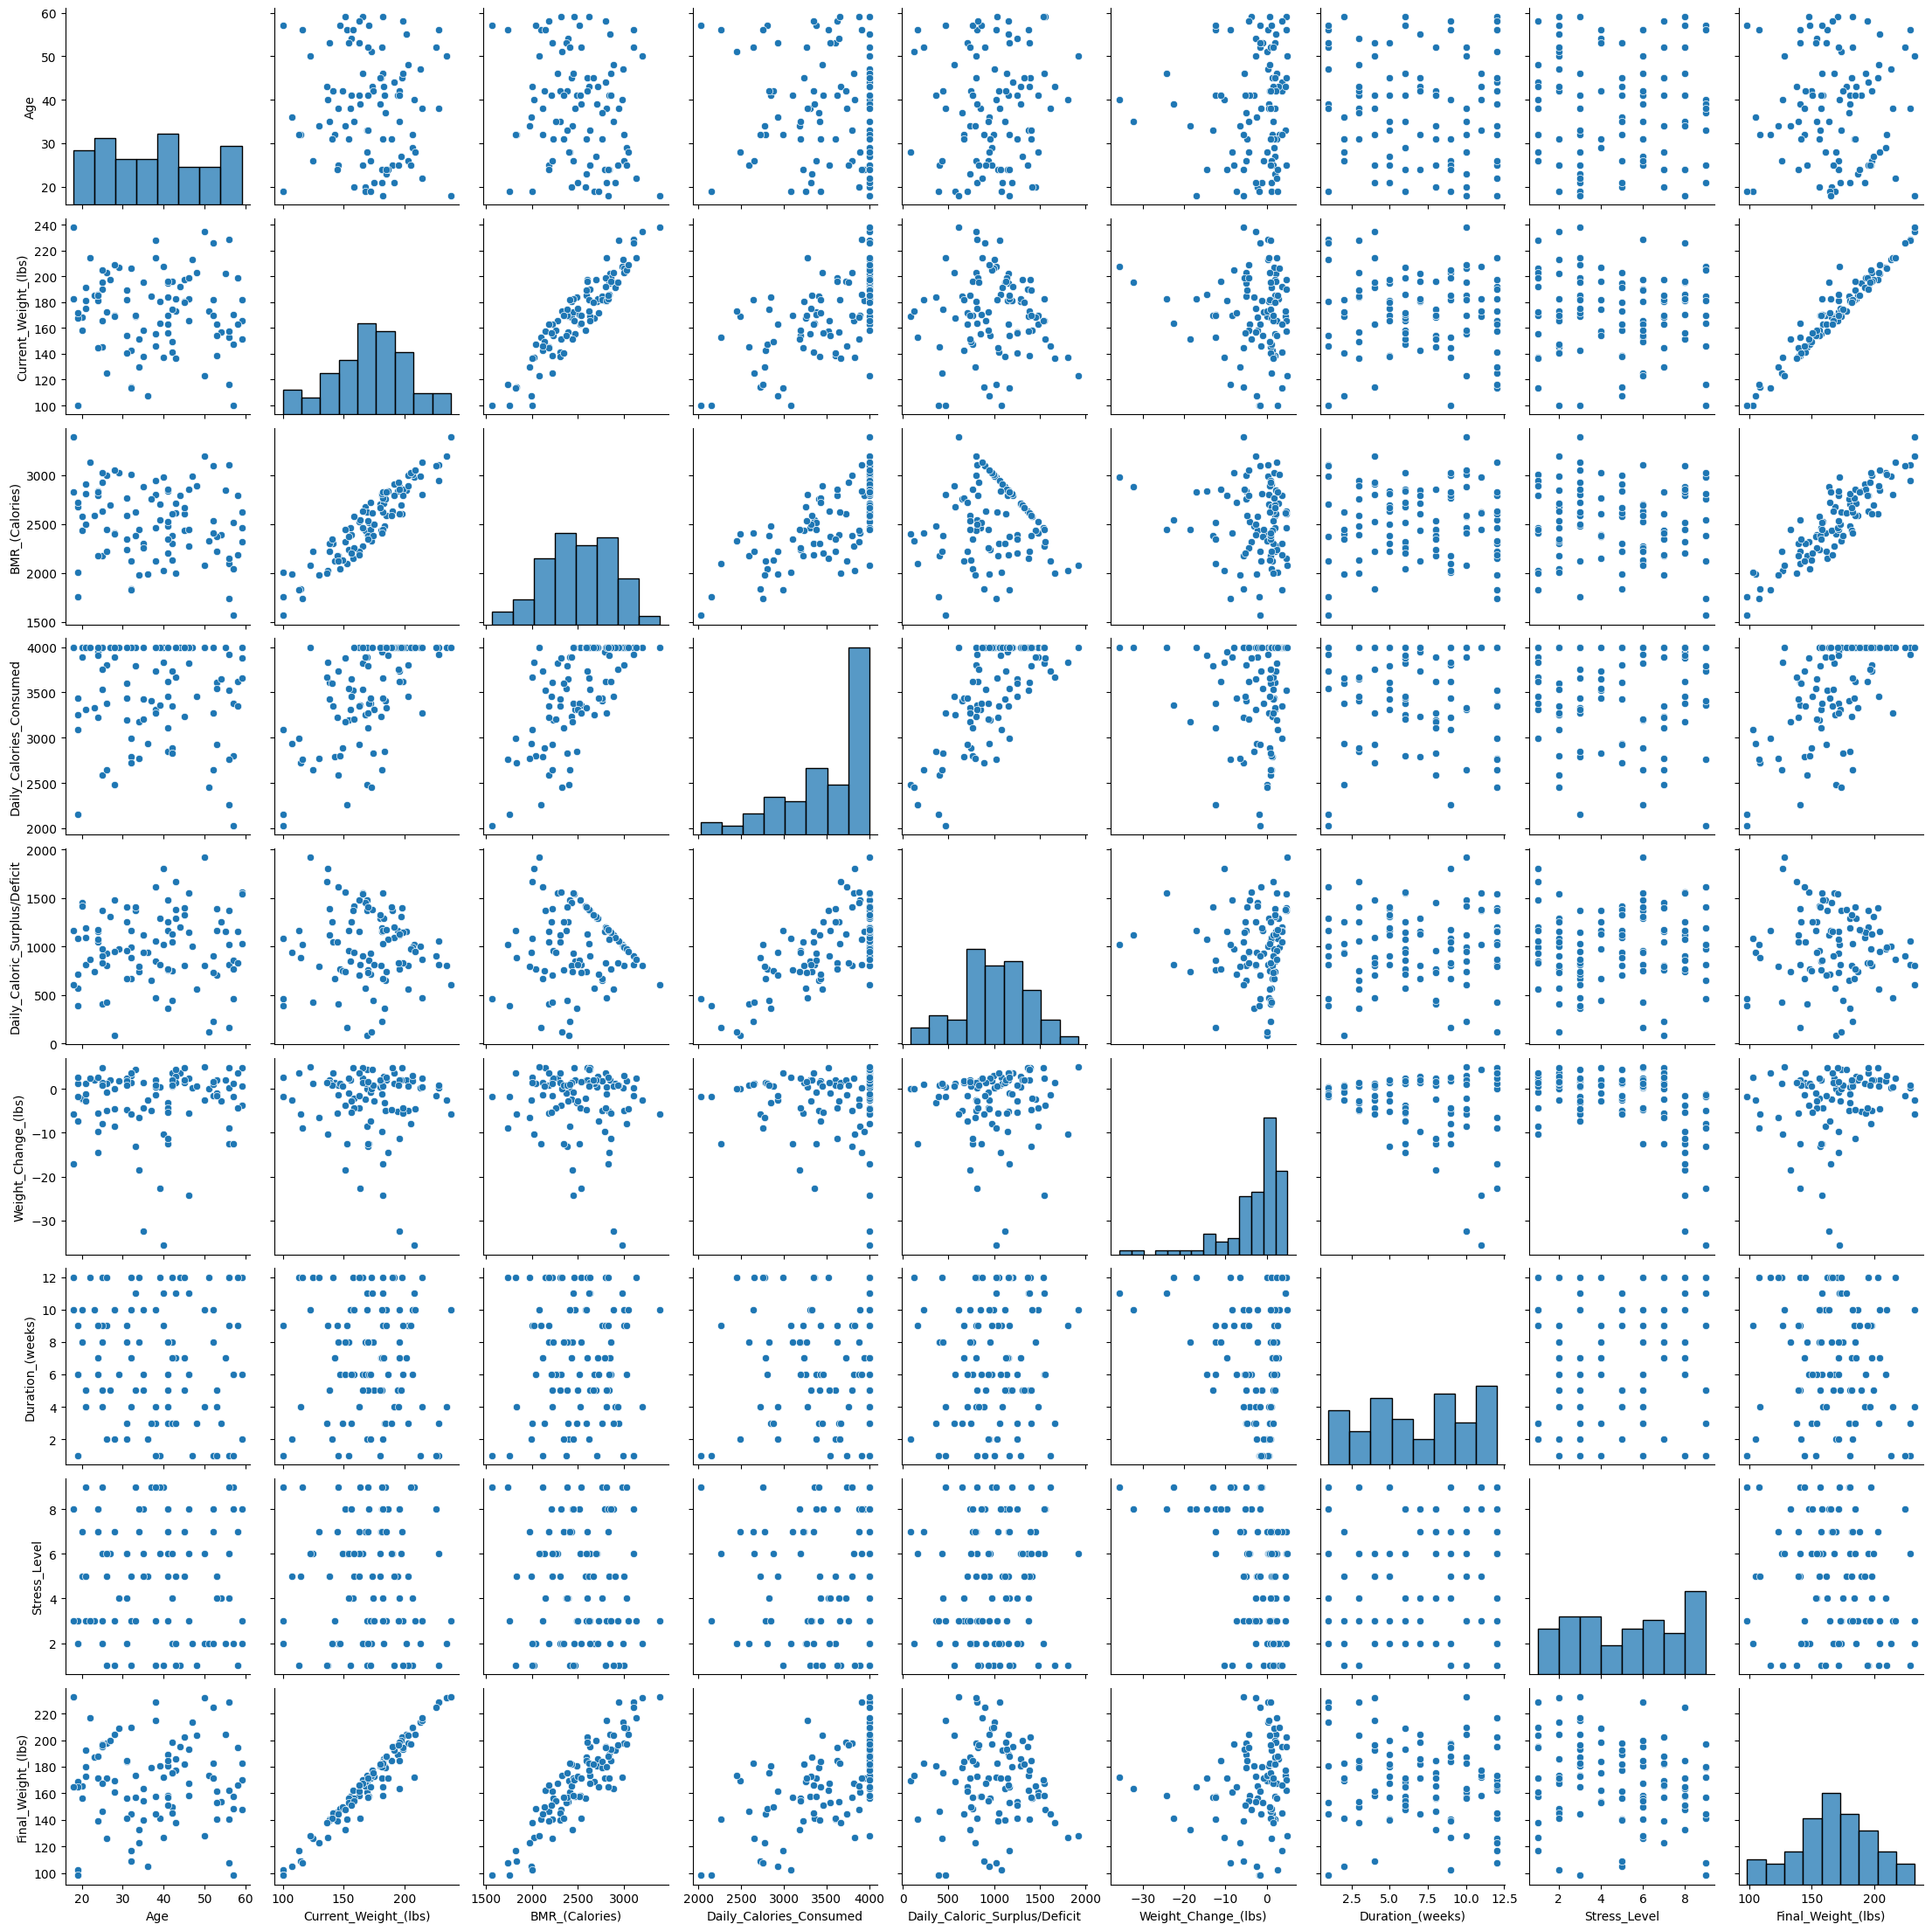

In [27]:
sns.pairplot(df)

In the pairplot above, we see that there is a strong positive relationship between current weight and basal metabolic rate (BMR) in calories.

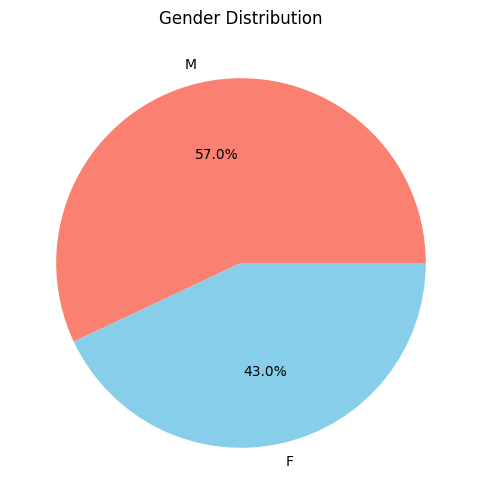

In [28]:
plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot.pie(
    autopct='%1.1f%%', colors=['salmon', 'skyblue'])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

As you can see, from our gathered data, there is more information on males than females.

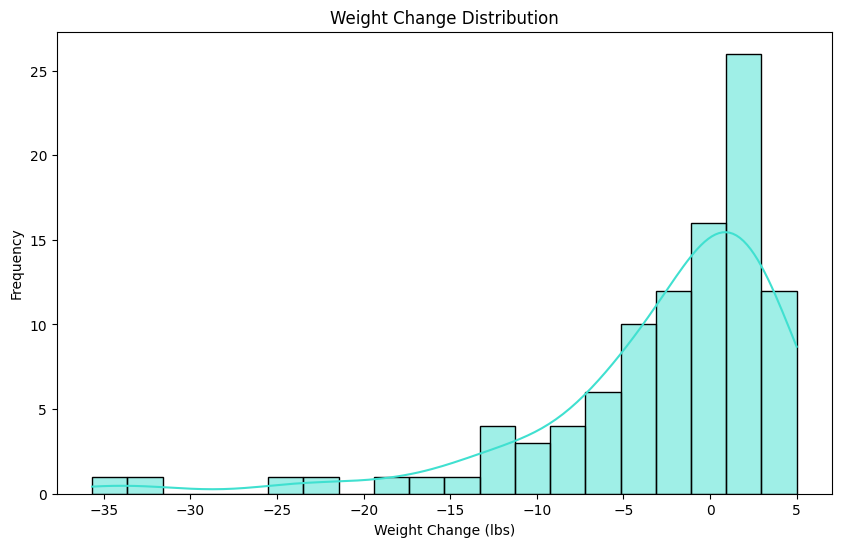

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data_encoded['Weight_Change_(lbs)'],
             bins=20, kde=True, color='turquoise')
plt.title('Weight Change Distribution')
plt.xlabel('Weight Change (lbs)')
plt.ylabel('Frequency')
plt.show()

The weight change distribution is skewed left, meaning that there were a handful of participants that lost over 15 pounds during this period of time. However the majority of participants remained within five pounds of the starting weight.

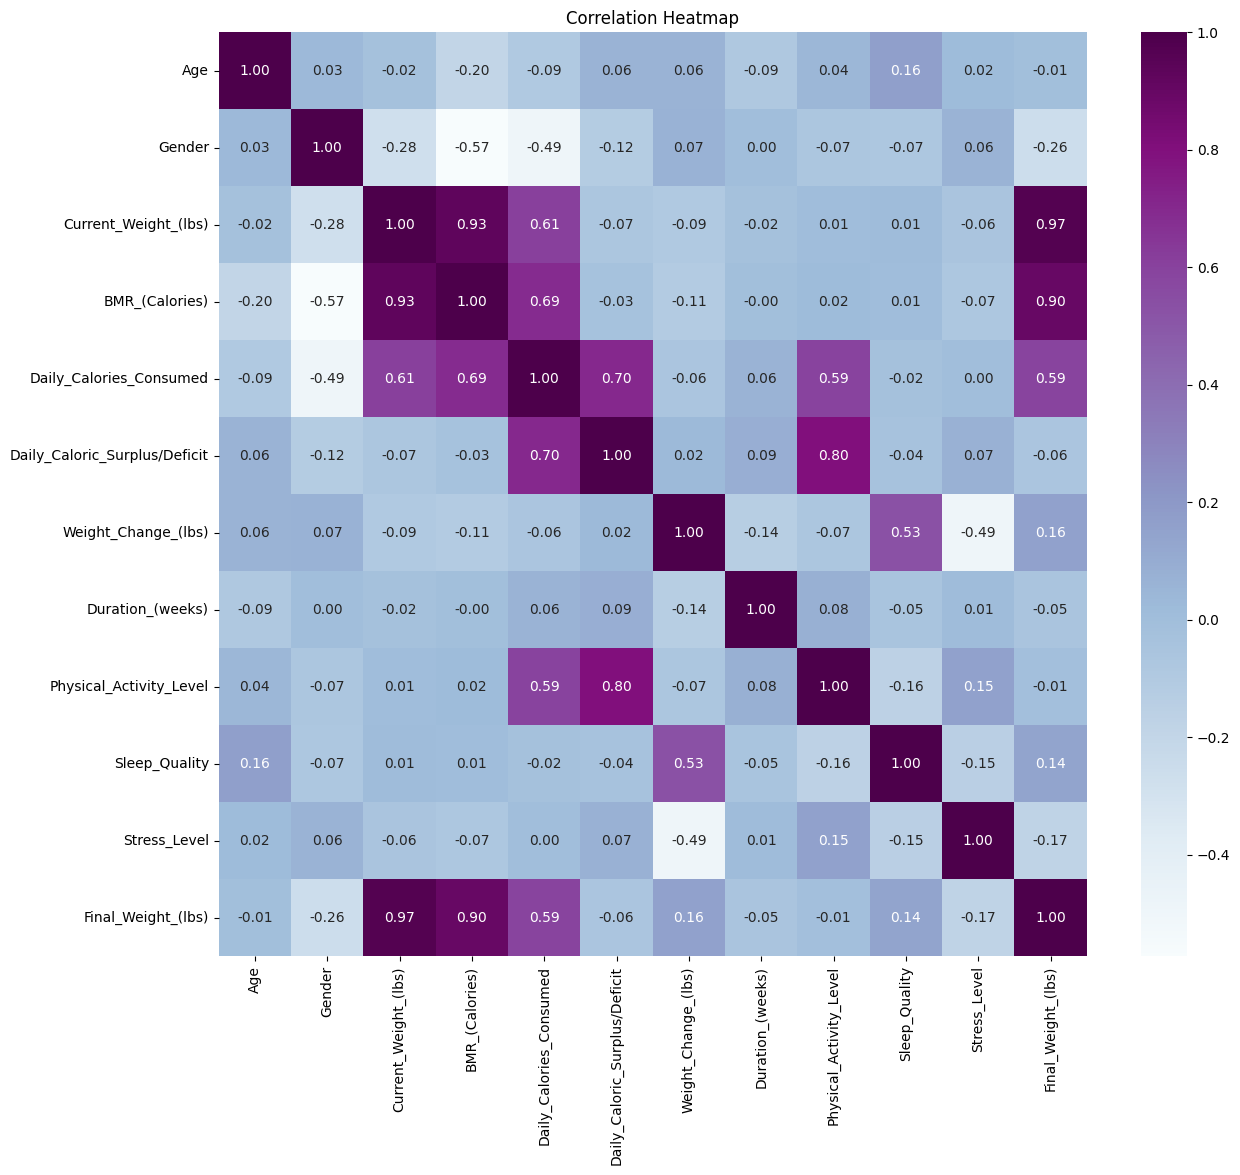

In [30]:
plt.figure(figsize=(14, 12))
numeric_cols = data_encoded.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='BuPu')
plt.title('Correlation Heatmap')
plt.show()

As mentioned before when looking at the pairplot above, we see that current weight and BMR (calories) are strongly correlated. BMR calories are also highly related to daily calories consumed and a participant's final weight. There is also a strong relationship between caloric deficit/surplus and physical activity which makes sense because calories are burned during exercise.

It appears that the final weight of a participant is related most strongly to a participant's current weight, BMR (calories), and daily calories consumed.

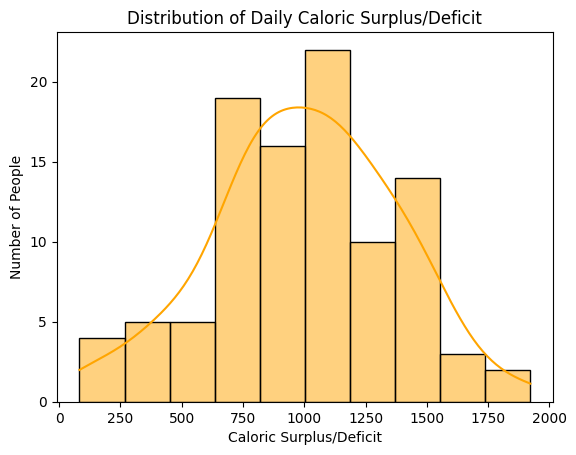

In [31]:
sns.histplot(data=data_encoded["Daily_Caloric_Surplus/Deficit"],
             bins=10, kde=True, color='orange', edgecolor='black')

# Add title and labels
plt.title("Distribution of Daily Caloric Surplus/Deficit")
plt.xlabel("Caloric Surplus/Deficit")
plt.ylabel("Number of People")

# Show the plot
plt.show()

The spread of participants caloric surplus/deficit is approximatedly normal, with a mean of 1000 calories.

C:\Users\mmech\AppData\Local\Temp\ipykernel_176\3719187355.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stress_level.index, y=stress_level.values, palette='viridis')


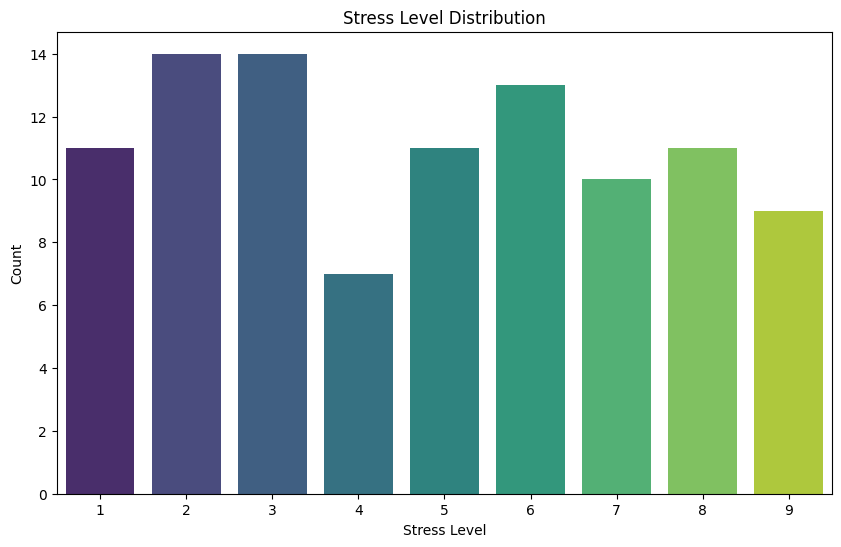

In [32]:


plt.figure(figsize=(10, 6))

stress_level = df['Stress_Level'].value_counts()
sns.barplot(x=stress_level.index, y=stress_level.values, palette='viridis')

plt.title('Stress Level Distribution')
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.show()

Stress level distribution doesn't appear to follow a particular trend, rather, each stress level has a decent amount of participants falling within it.

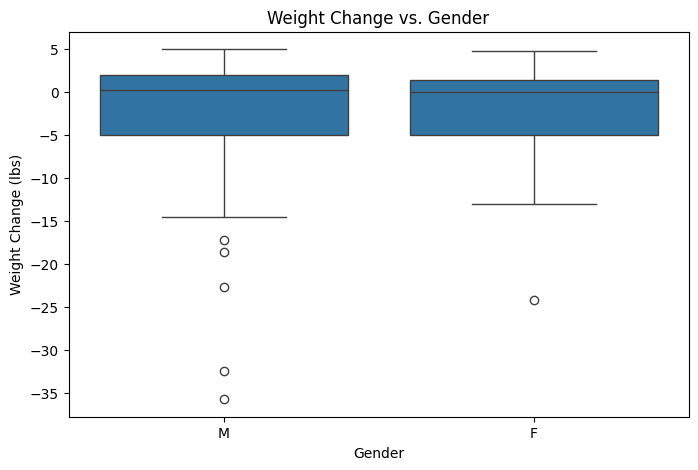

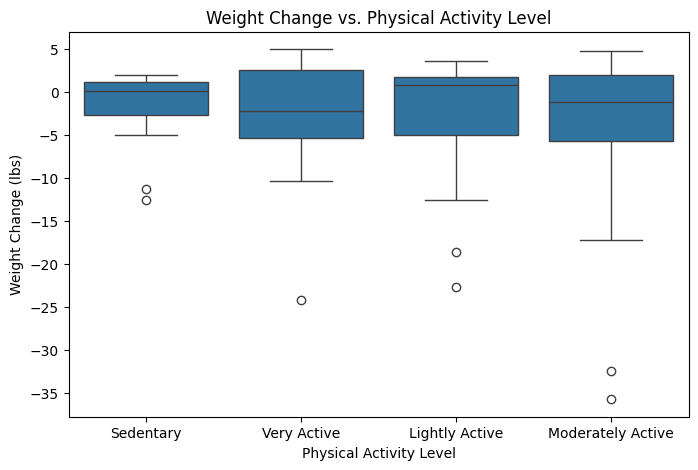

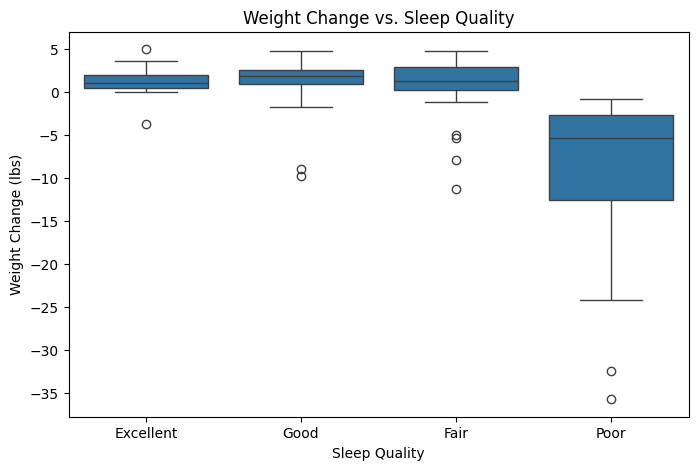

In [35]:
df = pd.read_csv('weight_change_dataset.csv')
df.head()

categorical_features = ['Gender', 'Physical Activity Level', 'Sleep Quality']

for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=feature, y='Weight Change (lbs)')
    plt.title(f'Weight Change vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Weight Change (lbs)')
    plt.show()

Gender does not appear to have much of an affect on weight loss/gain in general. Based on the first histogram above, we see that half of the male participants and half of the female participants had a positive weight change (gain) that fell between 0 and 5 pounds, while the remaining half of both parties lost somewhere between 0 and 15 pounds. The most significant difference between the two parties is that the males had five outliers that lost over 15 pounds, where the females only had one outlier in weight loss range.